## Choosing a threshold for the classifier
### Author: D. Tolosa

We explore all possible values for sensitivity and specificity of the classifier as we vary the threshold, and choose the one with sensitivity closest to 0.9 from above. We also produce plots to visualize the spread of the scores and linear scores, with AD and NCI differentiated.

**_This project was developed at The Data Mine, Purdue University, in partnership with Molecular Stethoscope._**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
### Reding csv file containing 243 subjects and their raw TPM counts across 1059 genes
### Source of data
myDF = pd.read_excel("/anvil/projects/tdm/corporate/molecular-stethoscope/data-s23/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name = 1)
# setting index row name to the gene id
myDF = myDF.set_index('gene_id')

### Step 1: Data prep

In [2]:
#Filtering out rows: discarding the ERCC rows, ERCC is a control protocol for validation of RNA sequencing
Patients_df = myDF[~myDF.loc[:,'Coeff'].isnull()]

# We store the coefficients(betas) of the linear classifier in an array.
coefficients = np.nan_to_num(np.array(Patients_df.loc[:, "Coeff"]))

# Filtering out columns with patient data
Patients_df = Patients_df.filter(regex='^\d+')

In [3]:
# group columns by patient id
grouped_cols = Patients_df.columns.str.split('-').str[0]
grouped = Patients_df.groupby(grouped_cols, axis=1)

# apply the mean function to the r1 and r2 columns for each group
# taking mean of the replicates for subjects with multiple replicates
Patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
# Patients_df.head()

### Step 2: Computing Zscores from TPM data

In [4]:
Patients_df['Mean']= Patients_df.mean(axis=1)
Patients_df['Std']=Patients_df.iloc[:,:-1].std(axis=1)
#Patients_df.head()

In [5]:
# We define a function whose input is TPM and outputs the corresponding Zscore
def z_score(x):
    return (x-x['Mean'])/x['Std']

In [6]:
# Computing and storing zscores
Patients_df_zScore = Patients_df.apply(lambda x: z_score(x), axis=1)
Patients_df_zScore = Patients_df_zScore.drop(columns=['Mean','Std'])
#Patients_df_zScore

### Step 3: Defining classifier functions

In [1]:
# This score is the classifer linear score, before converting to probability, i.e. sum (beta * zScores)
def linear_score(coefficients, col):
    linear_score = np.sum(coefficients * col, axis=0)
    return linear_score

# Function to perform anti-logit operation on the linear score 
def cl_score(linear_score, gamma = 0):
    temp = gamma + linear_score
    classifier_score = np.exp(temp) / (1 + np.exp(temp))
    return classifier_score

In [18]:
### save linear scores in a dataframe
subjects = Patients_df_zScore.columns.astype(str)
linear_scores_df = pd.DataFrame(columns = {'Subject', 'linear_score'},index = subjects)
for col in subjects:
    linear_scores_df.loc[col] = [int(col),linear_score(coefficients,Patients_df_zScore[col].values)]
    
linear_scores_df.head()

,Subject,linear_score
11174,11174,15.94548
11178,11178,-6.458822
11182,11182,6.245881
11186,11186,0.077761
11190,11190,2.491608


In [19]:
### load clinical diagnosis dataframe
pathos = pd.read_excel("data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name = 0)
pathos = pathos[~pathos.loc[:,'Isolate ID'].isna()]
pathos = pathos.astype({'Isolate ID':'int'})
pathos = pathos[pathos.loc[:,'Disease'].isin(['AD','NCI'])]
pathos

,Isolate ID,Disease
0,1817,NCI
1,1818,NCI
2,1821,NCI
3,1850,NCI
4,1854,NCI
...,...,...
239,17948,NCI
240,17949,NCI
241,17950,NCI
242,17951,NCI


In [20]:
### merge clinical diagnosis dataframe with the linear scores dataframe
master_df = pd.merge(pathos, linear_scores_df, left_on='Isolate ID', right_on='Subject')
master_df = master_df.drop(columns = ['Isolate ID'])
master_df.head()

,Disease,Subject,linear_score
0,NCI,1817,-10.375456
1,NCI,1818,-10.318006
2,NCI,1821,-9.261675
3,NCI,1850,-11.029938
4,NCI,1854,-11.170406


### Step 4: Plotting classifier scores in linear and exponential scales

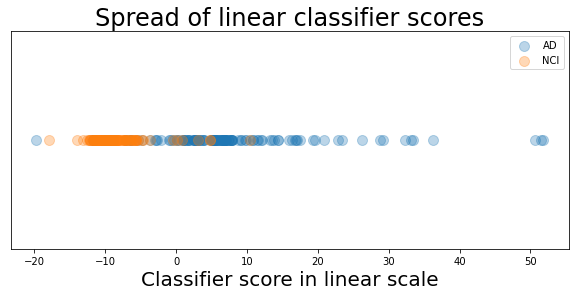

In [48]:
fig = plt.figure(figsize=(10,4))
groups = master_df.groupby("Disease")

for name, group in groups:
    y = np.ones(groups['Disease'].count().loc[name])
    plt.scatter(group['linear_score'],y, marker="o", label=name,cmap = 'Dark2_r' ,alpha = 0.3, s=100)
plt.legend()
plt.title('Spread of linear classifier scores', fontsize = 24)
plt.xlabel("Classifier score in linear scale", fontsize= 20)
plt.yticks([])
#plt.savefig('figures/spread_of_linear_classifier_scores.png')

([], [])

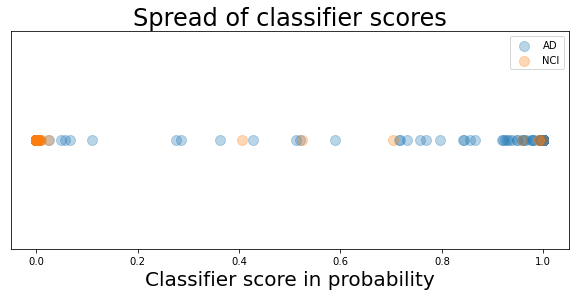

In [51]:
### In probability, i.e. exponential scale

fig = plt.figure(figsize=(10,4))
groups = master_df.groupby("Disease")

for name, group in groups:
    x = np.zeros(len(group['linear_score']))
    for i in range(len(group['linear_score'])):
        x[i] = cl_score(group['linear_score'].values[i])
    y = np.ones(groups['Disease'].count().loc[name])
    plt.scatter(x,y, marker="o", label=name,cmap = 'Dark2_r' ,alpha = 0.3, s=100)
plt.legend()
#plt.scatter(x,y,cmap = 'Dark2_r' ,alpha = 0.15, s=100)
plt.title('Spread of classifier scores', fontsize = 24)
plt.xlabel("Classifier score in probability", fontsize= 20)
plt.yticks([])
#plt.savefig('figures/spread_of_classifier_scores.png')

### Step 5: Computing sensitivity and specificity

In [43]:
### First we sort the master dataframe along the linear scores in descending order
master_df = master_df.sort_values(by=['linear_score'], ascending=True, ignore_index=True)
#master_df.head()
sens_vector = np.zeros(len(master_df))
spec_vector = np.zeros(len(master_df))

for subject in range(len(master_df)):
    sens_vector[subject] = sum(master_df.loc[subject:]['Disease'] == 'AD') / (sum(master_df.loc[subject:]['Disease'] == 'AD') + sum(master_df.loc[0:subject]['Disease'] == 'AD'))
    spec_vector[subject] = sum(master_df.loc[0:subject]['Disease'] == 'NCI') / (sum(master_df.loc[0:subject]['Disease'] == 'NCI') + sum(master_df.loc[subject:]['Disease'] == 'NCI'))
master_df['Sensitivity'] = sens_vector
master_df['Specificity'] = spec_vector

In [44]:
master_df[(master_df['Sensitivity'] > 0.9) & (master_df['Specificity'] > 0.9)]

,Disease,Subject,linear_score,Sensitivity,Specificity
112,AD,2537,-5.4282,0.929688,0.904348
113,NCI,5656,-5.324128,0.929134,0.905172
114,NCI,17944,-4.838643,0.929134,0.913793
115,AD,2553,-4.791915,0.921875,0.921739
116,NCI,17928,-4.630659,0.921260,0.922414
117,NCI,5644,-3.685555,0.921260,0.931034
118,AD,5784,-3.68194,0.914062,0.939130
119,AD,2529,-2.971084,0.906250,0.939130


In [45]:
### save the dataframe
master_df.to_csv('Cutoffs_Dan.csv')

In [2]:
cl_score(-2.971084)

NameError: name 'np' is not defined